In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import math

In [58]:
# normalize the dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load the MNIST dataset, without normalization
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# labels
print ("\nLabels:", train_dataset.classes)

# digits of the images
print ("\nClasses:", train_dataset.targets)

# shape of the data tensor
print ("\nData shape:", train_dataset.data.shape)


Labels: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

Classes: tensor([5, 0, 4,  ..., 5, 6, 8])

Data shape: torch.Size([60000, 28, 28])


torch.Size([10, 1, 28, 28])

Labels: tensor([4, 2, 8, 5, 9, 6, 4, 4, 2, 5])


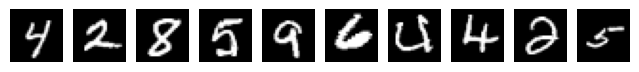

In [59]:
# number of images to visualize
num_examples = 10

# define a dataloader so that we can get images
train_loader = DataLoader(train_dataset, batch_size=num_examples, shuffle=True)
# get some images
for data in train_loader:
    img, label = data 
    break

# print the shape of the image tensor
print (img.shape)

# label of images
print ("\nLabels:", label)

plt.figure(figsize=(8, 4))
# visualize the images 
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(img[i].numpy().reshape(28,28), cmap='gray')
    plt.axis('off')


number of images in dataset: 1000


/tmp/ipykernel_8870/1974877405.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4, 2))


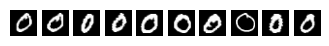

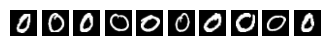

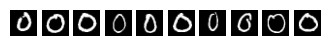

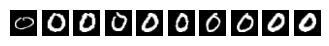

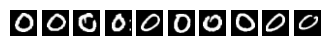

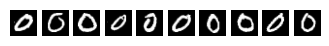

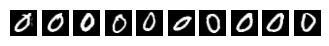

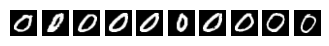

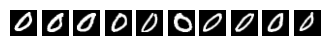

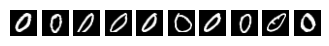

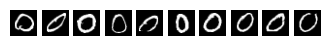

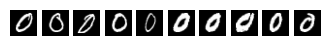

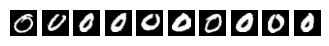

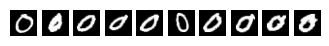

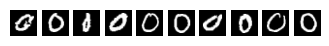

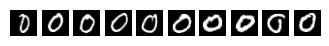

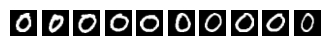

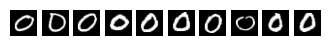

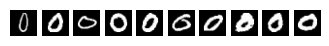

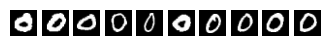

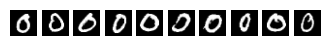

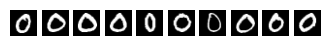

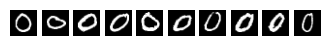

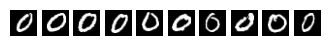

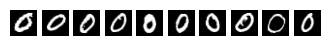

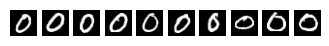

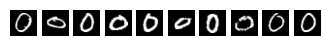

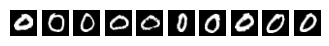

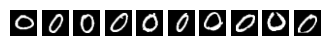

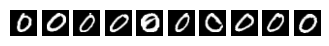

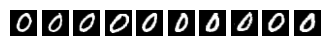

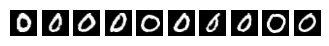

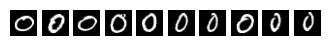

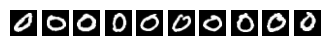

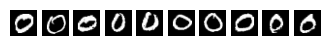

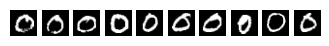

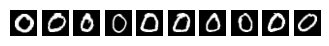

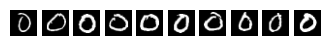

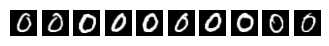

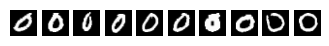

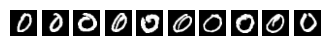

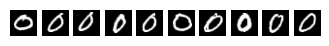

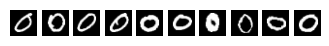

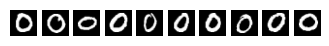

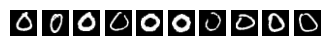

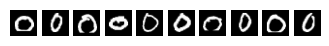

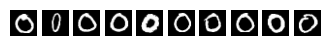

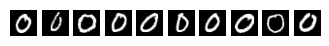

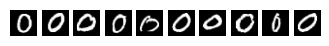

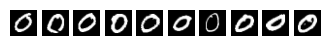

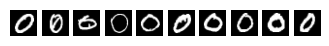

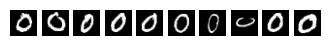

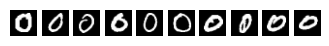

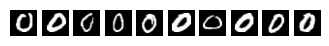

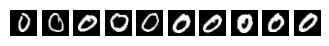

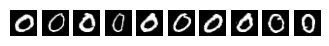

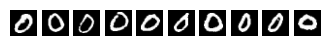

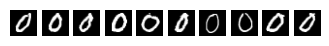

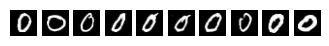

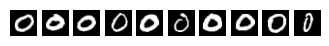

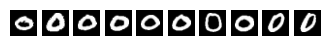

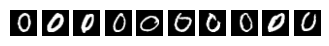

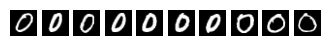

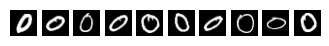

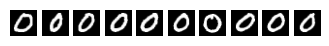

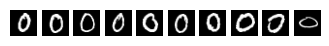

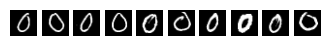

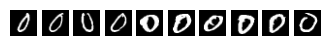

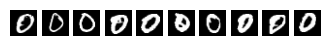

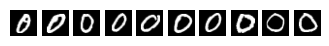

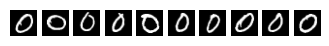

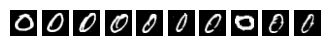

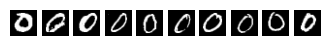

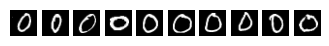

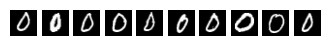

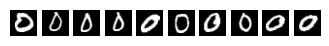

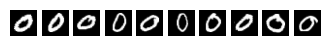

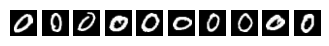

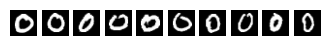

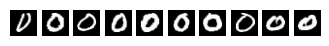

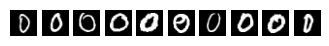

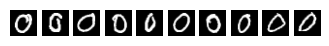

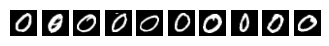

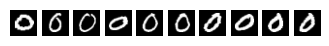

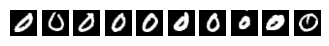

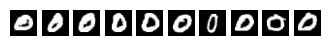

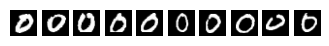

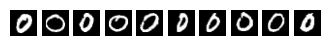

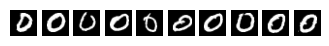

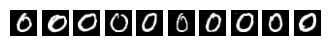

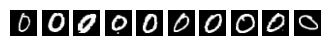

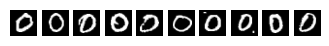

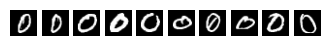

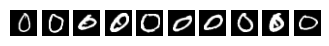

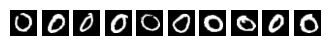

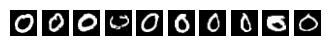

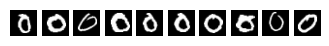

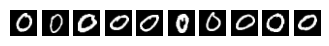

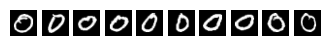

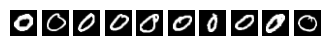

In [4]:
from torch.utils.data import Subset

# number of images to show 
num_examples = 10

selected_indices = []
# loop over labels
for label in range(1):
    
    # select indices with the matching label
    indices = torch.where(train_dataset.targets == label)[0]
    
    selected_indices.append(indices[0:1000])
    
selected_indices = torch.cat(selected_indices)    

# define a dataset only with images with matching label
dataset = Subset(train_dataset, selected_indices)
# shape of the data tensor
print ("\nnumber of images in dataset:", len(dataset))

# define a dataloader for this (sub)-dataset
data_loader = DataLoader(dataset, batch_size=10, shuffle=False)
    
# get some images
for data in data_loader:
    img, labels = data 
    plt.figure(figsize=(4, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(img[i].numpy().reshape(28,28), cmap='gray')
        plt.axis('off')

In [5]:
class VESDE: 
    def __init__(self, sigma_min, sigma_max, dim=1, T=1):

        self.T = T
        self.dim = dim
        
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
    
    def drift(self, X, t):
        return torch.zeros_like(X)
    
    def diffusion(self, t):

        sigma = self.sigma_min * (self.sigma_max/self.sigma_min) ** (t/self.T) 

        ret = sigma  * torch.sqrt(1.0 / self.T \
                                  * torch.tensor(2 * (math.log(self.sigma_max) - math.log(self.sigma_min))))
        
        return ret

    def marginal_prob(self, X, t):
        mean = X
        std = self.sigma_min * (self.sigma_max/self.sigma_min) ** (t/self.T) 
        return mean, std 

    def prior(self, M):
        return torch.randn(M * self.dim).reshape(-1, self.dim) * self.sigma_max
    
    # sample the SDE using Euler-Maruyama scheme
    def forward_sampling(self, X0, N=100):
        
        if torch.is_tensor(X0) is False:
            X = torch.tensor(X0).reshape(-1, self.dim)
        else :
            X = X0.reshape(-1, self.dim)
                
        traj = [X]
        delta_t = self.T / N

        for i in range(N):

            b = torch.randn_like(X)

            t = i * delta_t * torch.ones(X.shape[0]).reshape(-1, 1)
            
            drift = self.drift(X, t)

            diffusion_coeff = self.diffusion(t)

            X = X + drift * delta_t + diffusion_coeff * math.sqrt(delta_t) * b

            traj.append(X)

        return torch.stack(traj)

    # sample the SDE using Euler-Maruyama scheme
    def backward_sampling(self, X0, model, N=100): 
        
        if torch.is_tensor(X0) is False:
            X = torch.tensor(X0).reshape(-1, self.dim)
        else :           
            X = X0.reshape(-1, self.dim)
        traj = [X]
        delta_t = self.T / N

        for i in range(N):
            
            b = torch.randn_like(X)

            t = self.T - i * delta_t * torch.ones(X.shape[0]).reshape(-1, 1)

            score = model(X.reshape(-1,1,28,28), t).reshape(-1,self.dim)
            
            drift = self.drift(X, t)
            diffusion_coeff = self.diffusion(t)

            X = X + (-1.0 * drift + diffusion_coeff**2 * score) * delta_t + math.sqrt(delta_t) * diffusion_coeff * b

            traj.append(X)

        return torch.stack(traj) 

In [6]:
T = 1

sigma_min = 0.03
sigma_max = 2
dim = 28 * 28
sde = VESDE(sigma_min, sigma_max, dim=dim, T=T)

In [7]:
# get some images
for data in data_loader:
    img, label = data 
    break
    
traj = sde.forward_sampling(img, N=1000)

print (torch.min(traj[0,:,:]), torch.max(traj[0,:,:]))

print (torch.min(traj[-1,:,:]), torch.max(traj[-1,:,:]))



tensor(-1.) tensor(1.)
tensor(-10.3826) tensor(8.1991)


torch.Size([1001, 10, 784])


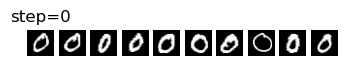

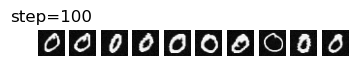

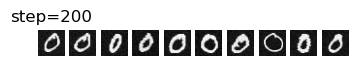

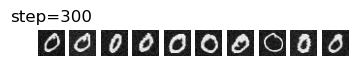

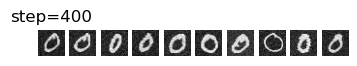

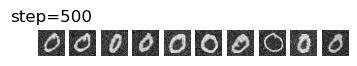

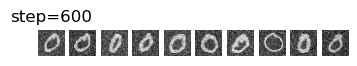

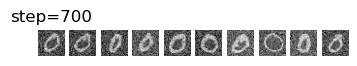

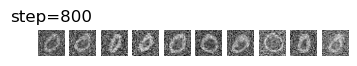

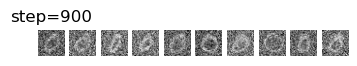

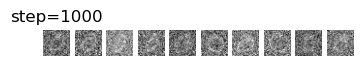

In [8]:
print (traj.shape)

for step in range(traj.shape[0]):
    if step % 100 == 0 :
        plt.figure(figsize=(4, 2))
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(traj[step, i, :].reshape(28,28), cmap='gray')
            plt.axis('off')
            if i == 0 : 
                plt.title("step=%d" % step)

In [56]:
class ChannelShuffle(nn.Module):
    def __init__(self,groups):
        super().__init__()
        self.groups=groups
    def forward(self,x):
        n,c,h,w=x.shape
        x=x.view(n,self.groups,c//self.groups,h,w) # group
        x=x.transpose(1,2).contiguous().view(n,-1,h,w) #shuffle
        
        return x

class ConvBnSiLu(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride=1,padding=0):
        super().__init__()
        self.module=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
                                  nn.BatchNorm2d(out_channels),
                                  nn.SiLU(inplace=True))
    def forward(self,x):
        return self.module(x)

class ResidualBottleneck(nn.Module):
    '''
    shufflenet_v2 basic unit(https://arxiv.org/pdf/1807.11164.pdf)
    '''
    def __init__(self,in_channels,out_channels):
        super().__init__()

        self.branch1=nn.Sequential(nn.Conv2d(in_channels//2,in_channels//2,3,1,1,groups=in_channels//2),
                                    nn.BatchNorm2d(in_channels//2),
                                    ConvBnSiLu(in_channels//2,out_channels//2,1,1,0))
        self.branch2=nn.Sequential(ConvBnSiLu(in_channels//2,in_channels//2,1,1,0),
                                    nn.Conv2d(in_channels//2,in_channels//2,3,1,1,groups=in_channels//2),
                                    nn.BatchNorm2d(in_channels//2),
                                    ConvBnSiLu(in_channels//2,out_channels//2,1,1,0))
        self.channel_shuffle=ChannelShuffle(2)

    def forward(self,x):
        x1,x2=x.chunk(2,dim=1)
        x=torch.cat([self.branch1(x1),self.branch2(x2)],dim=1)
        x=self.channel_shuffle(x) #shuffle two branches

        return x

class ResidualDownsample(nn.Module):
    '''
    shufflenet_v2 unit for spatial down sampling(https://arxiv.org/pdf/1807.11164.pdf)
    '''
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.branch1=nn.Sequential(nn.Conv2d(in_channels,in_channels,3,2,1,groups=in_channels),
                                    nn.BatchNorm2d(in_channels),
                                    ConvBnSiLu(in_channels,out_channels//2,1,1,0))
        self.branch2=nn.Sequential(ConvBnSiLu(in_channels,out_channels//2,1,1,0),
                                    nn.Conv2d(out_channels//2,out_channels//2,3,2,1,groups=out_channels//2),
                                    nn.BatchNorm2d(out_channels//2),
                                    ConvBnSiLu(out_channels//2,out_channels//2,1,1,0))
        self.channel_shuffle=ChannelShuffle(2)

    def forward(self,x):
        x=torch.cat([self.branch1(x),self.branch2(x)],dim=1)
        x=self.channel_shuffle(x) #shuffle two branches

        return x

class TimeMLP(nn.Module):
    '''
    naive introduce timestep information to feature maps with mlp and add shortcut
    '''
    def __init__(self,embedding_dim,hidden_dim,out_dim):
        super().__init__()
        self.mlp=nn.Sequential(nn.Linear(embedding_dim,hidden_dim),
                                nn.SiLU(),
                               nn.Linear(hidden_dim,out_dim))
        self.act=nn.SiLU()
    def forward(self,x,t):
        t_emb=self.mlp(t).unsqueeze(-1).unsqueeze(-1)
        x=x+t_emb
  
        return self.act(x)
    
class EncoderBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_embedding_dim):
        super().__init__()
        self.conv0=nn.Sequential(*[ResidualBottleneck(in_channels,in_channels) for i in range(3)],
                                    ResidualBottleneck(in_channels,out_channels//2))

        self.time_mlp=TimeMLP(embedding_dim=time_embedding_dim,hidden_dim=out_channels,out_dim=out_channels//2)
        self.conv1=ResidualDownsample(out_channels//2,out_channels)
    
    def forward(self,x,t=None):
        x_shortcut=self.conv0(x)
        if t is not None:
            x=self.time_mlp(x_shortcut,t)
        x=self.conv1(x)

        return [x,x_shortcut]
        
class DecoderBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_embedding_dim):
        super().__init__()
        self.upsample=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False)
        self.conv0=nn.Sequential(*[ResidualBottleneck(in_channels,in_channels) for i in range(3)],
                                    ResidualBottleneck(in_channels,in_channels//2))

        self.time_mlp=TimeMLP(embedding_dim=time_embedding_dim,hidden_dim=in_channels,out_dim=in_channels//2)
        self.conv1=ResidualBottleneck(in_channels//2,out_channels//2)

    def forward(self,x,x_shortcut,t=None):
        x=self.upsample(x)
        x=torch.cat([x,x_shortcut],dim=1)
        x=self.conv0(x)
        if t is not None:
            x=self.time_mlp(x,t)
        x=self.conv1(x)

        return x        

class Unet(nn.Module):
    '''
    simple unet design without attention
    '''
    def __init__(self,timesteps,time_embedding_dim,in_channels=1,out_channels=1,base_dim=32,dim_mults=[2,4,8,16]):
        super().__init__()
        assert isinstance(dim_mults,(list,tuple))
        assert base_dim%2==0 

        channels=self._cal_channels(base_dim,dim_mults)

        self.init_conv=ConvBnSiLu(in_channels,base_dim,3,1,1)
        self.time_embedding=nn.Embedding(timesteps,time_embedding_dim)

        self.encoder_blocks=nn.ModuleList([EncoderBlock(c[0],c[1],time_embedding_dim) for c in channels])
        self.decoder_blocks=nn.ModuleList([DecoderBlock(c[1],c[0],time_embedding_dim) for c in channels[::-1]])
    
        self.mid_block=nn.Sequential(*[ResidualBottleneck(channels[-1][1],channels[-1][1]) for i in range(2)],
                                        ResidualBottleneck(channels[-1][1],channels[-1][1]//2))

        self.final_conv=nn.Conv2d(in_channels=channels[0][0]//2,out_channels=out_channels,kernel_size=1)

    def forward(self,x,t=None):
        x = x.reshape(-1,1,28,28)
        x=self.init_conv(x)
        #if t is not None:
        #    t=self.time_embedding(t)
        encoder_shortcuts=[]
        for encoder_block in self.encoder_blocks:
            x,x_shortcut=encoder_block(x,t)
            encoder_shortcuts.append(x_shortcut)
        x=self.mid_block(x)
        encoder_shortcuts.reverse()
        for decoder_block,shortcut in zip(self.decoder_blocks,encoder_shortcuts):
            x=decoder_block(x,shortcut,t)
        x=self.final_conv(x)

        return x

    def _cal_channels(self,base_dim,dim_mults):
        dims=[base_dim*x for x in dim_mults]
        dims.insert(0,base_dim)
        channels=[]
        for i in range(len(dims)-1):
            channels.append((dims[i],dims[i+1])) # in_channel, out_channel

        return channels

if __name__=="__main__":
    x=torch.randn(3,1,28,28)
    t=torch.randn(3,1)
    model=Unet(1000,1, dim_mults=[2,4])
    y=model(x,t)
    print (t)
    print(y.shape)
    
model=Unet(1000,1, base_dim=16, dim_mults=[2,4])

pytorch_total_params = sum(p.numel() for p in model.parameters())

print ("No. params: ", pytorch_total_params)

tensor([[ 0.3452],
        [-0.6612],
        [-1.9601]])
torch.Size([3, 1, 28, 28])
No. params:  52129


In [36]:
class MyScore(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(28*28+1, 128),
            nn.Tanh(),
            nn.Linear(128, 128), 
            nn.Tanh(),
            nn.Linear(128, 128), 
            nn.Tanh(),
            nn.Linear(128, 28*28), 
       )
        
    # define how the output of model is computed given input x
    def forward(self, x, t):
        
        state = torch.cat((x, t), dim=1)
        output = self.net(state)
        
        return output
    
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(1, 1, 1)
        self.fc1 = nn.Linear(16 * 4 * 4 + 1, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 28*28)

    def forward(self, x, t):
        x = x.reshape(-1,1,28,28)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch        
        x = torch.cat((x, t), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x).reshape(-1,1,28,28)
        x = self.conv3(x)
        return x

model = Net()    

epoch=0
   loss=3.1663
epoch=2
   loss=0.1829
epoch=4
   loss=-3.6266
epoch=6
   loss=-11.6726
epoch=8
   loss=-15.5590
epoch=10
   loss=-27.4253
epoch=12
   loss=-34.4269
epoch=14
   loss=-39.3461
epoch=16
   loss=-55.1246
epoch=18
   loss=-63.8402
epoch=20
   loss=-70.1410
epoch=22
   loss=-74.8060
epoch=24
   loss=-82.8409
epoch=26
   loss=-90.8849
epoch=28
   loss=-108.4546
epoch=30
   loss=-107.6344
epoch=32
   loss=-105.7722
epoch=34
   loss=-118.4605
epoch=36
   loss=-106.5374
epoch=38
   loss=-123.9859
epoch=40
   loss=-145.9643
epoch=42
   loss=-131.6811
epoch=44
   loss=-146.2865
epoch=46
   loss=-153.2630
epoch=48
   loss=-161.2374


Text(0.5, 1.0, 'loss vs epoch')

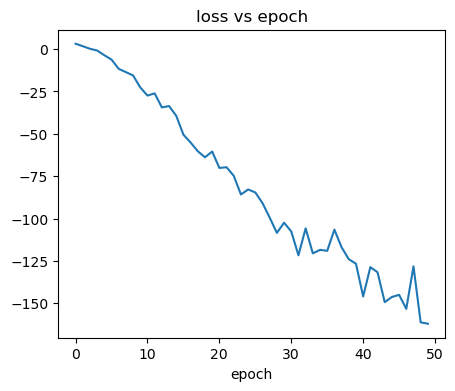

In [50]:
# batch-size
batch_size = 100

# total training epochs
total_epochs = 50

# represent the function g using a neural network
 
# Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

loss_list = []

for epoch in range(total_epochs):   # for each epoch
    
    for idx, data in enumerate(data_loader):  # loop over all mini-batches 
        
        img, label = data
        img = img.reshape(-1, dim)
        
        t = torch.rand(img.shape[0]).reshape(-1,1) * T 
        
        mean, std_t = sde.marginal_prob(img, t)    
               
        z = torch.randn_like(img)       
                
        xt = img + std_t * z

        score = model(xt,t).reshape(-1,dim) 

        loss_batch = 0.5*torch.sum(score**2, dim=1, keepdim=True) \
                     + torch.sum(score * z, dim=1, keepdim=True) / std_t

        loss = torch.mean(loss_batch * std_t**2)
                
        optimizer.zero_grad()
        # gradient step
        loss.backward()
        # update weights
        optimizer.step()
        
        if idx == 0:
            # record the loss    
            loss_list.append(loss.item())  
            if epoch % 2 == 0:
                print ('epoch=%d\n   loss=%.4f' % (epoch, loss.item()))   
                
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.plot(loss_list)
ax.set_xlabel('epoch')
ax.set_title('loss vs epoch')             

In [51]:
            
with torch.no_grad():
    # generate a long trajectory 
    X = sde.prior(10)
    
    trajectory = sde.backward_sampling(X, model, N=100)

print (torch.min(trajectory[0,:,:]), torch.max(trajectory[0,:,:]))

print (torch.min(trajectory[-1,:,:]), torch.max(trajectory[-1,:,:]))

print ("Number of states:", trajectory.shape)

tensor(-7.6467) tensor(7.0662)
tensor(-9.9086) tensor(9.2896)
Number of states: torch.Size([101, 10, 784])


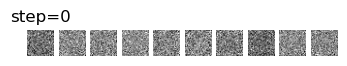

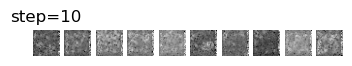

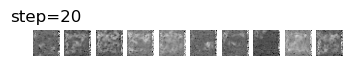

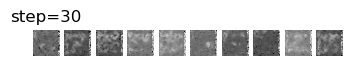

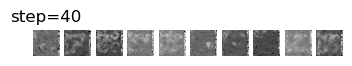

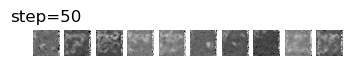

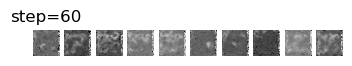

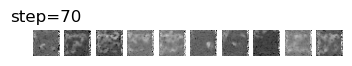

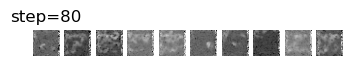

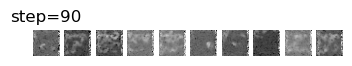

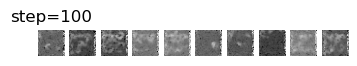

In [52]:
for step in range(trajectory.shape[0]):
    if step % 10 == 0 :
        plt.figure(figsize=(4, 2))
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(trajectory[step, i, :].reshape(28,28), cmap='gray')
            plt.axis('off')
            if i == 0 : 
                plt.title("step=%d" % step)